# Project: A/B test of e-commerce company webpage

## Project Background
GloBox is an online marketplace that specializes in sourcing unique and high-quality products from around the world. GloBox is primarily known amongst its customer base for boutique fashion items and high-end decor products. However, companies' food and drink offerings have grown tremendously in the last few months, and the company wants to bring awareness to this product category to increase revenue. The Growth team decides to run an A/B test that highlights key products in the food and drink category as a banner at the top of the website. The control group does not see the banner, and the test group sees it as shown below:

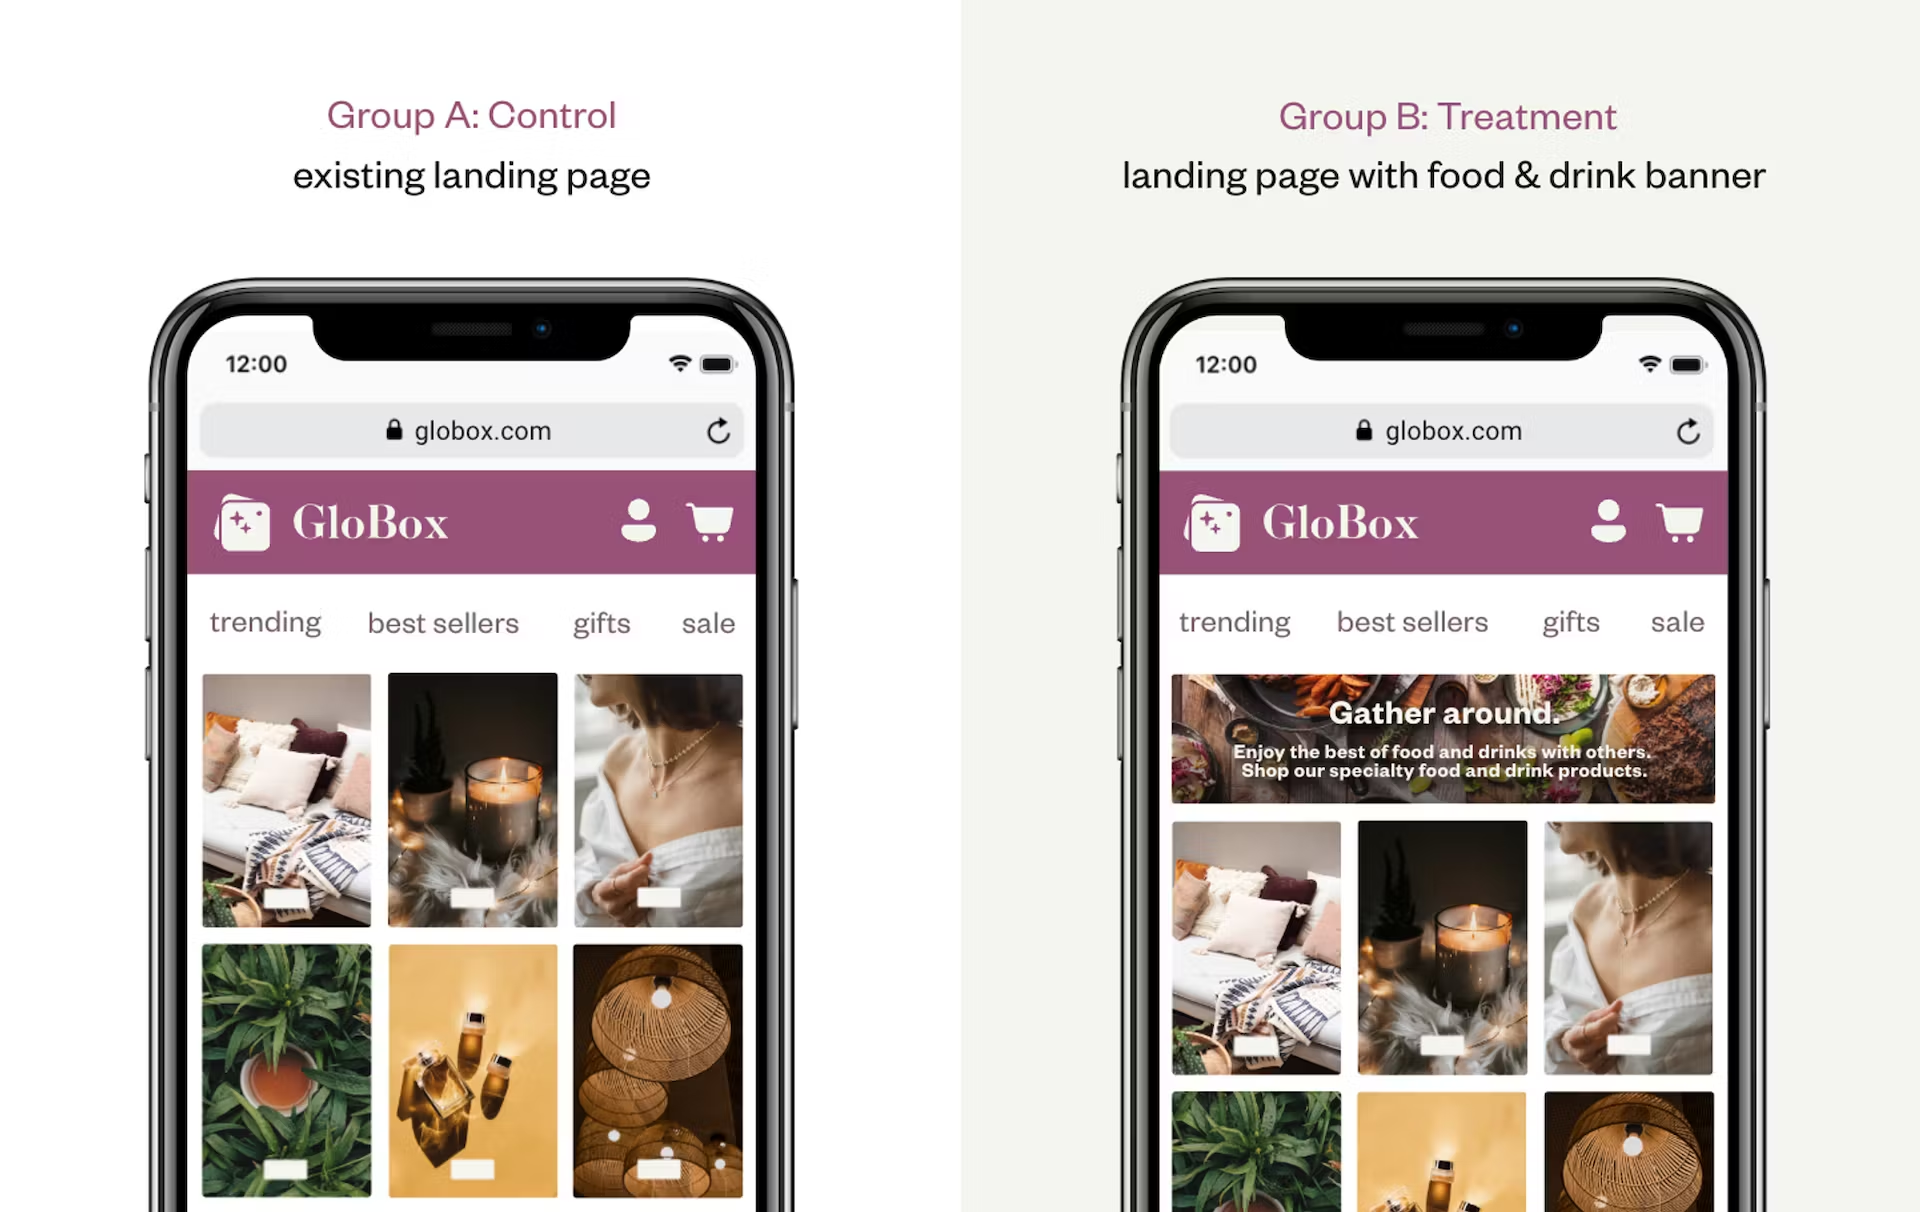

**The setup of the A/B test is as follows:**

1. The experiment is only being run on the mobile website.
2. A user visits the GloBox main page and is randomly assigned to either the control or test group. This is the join date for the user.
3. The page loads the banner if the user is assigned to the test group, and does not load the banner if the user is assigned to the control group.
4. The user subsequently may or may not purchase products from the website. It could be on the same day they join the experiment, or days later. If they do make one or more purchases, this is considered a “conversion”.  

Our task is to analyze the results of the A/B test and provide a recommendation to the stakeholders about whether GloBox should launch the experience to all users.

## The Dataset
GloBox stores its data in a relational [database](https://bit.io/griffinmasterschool/ab_test_project?tab=Data). We will be using the following datastest.  

1. **users** - user demographic information
    - _id_ - the user ID
    - _country_ - ISO 3166 alpha-3 country code
    - _gender_ - the user's gender (M = male, F = female, O = other)
    
    
2. **groups** - user A/B test group assignment
    - _uid_ - the user ID
    - _group_ - the user’s test group
    - _join_dt_ - the date the user joined the test (visited the page)
    - _device_ - the device the user visited the page on (I = iOS, A = android)
    
    
3. **activity** - user purchase activity, containing 1 row per day that a user made a purchase
    - _uid_ - the user ID
    - _dt_ - date of purchase activity
    - _device_ - the device type the user purchased on (I = iOS, A = android)
    - _spent_ - the purchase amount in USD

We used SQL commands below to get all the data from the relational database then download it in csv format. All the further data preprocessing and analysis have been done in Python.
> SELECT * 
FROM users

> SELECT * 
FROM groups

> SELECT * 
FROM activity 

## Data Gathering
In the cell below, gather all three pieces of data for this project and load them in the notebook.

In [1]:
#Import libraries needed
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Change the settings to show all the data frame or the cell content
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)

In [2]:
# Set the path to the folder containing the CSV files
path = r'C:\Users\manuk\OneDrive\Desktop\MasterSchool_final\Career Accelerator 201_Mastery Projects\Dataset'

# Change the current working directory to the specified path
os.chdir(path)

# Load the CSV files into Pandas DataFrames
activity = pd.read_csv('activity.csv')
users = pd.read_csv('users.csv')
groups = pd.read_csv('groups.csv')

In [3]:
# Check the number of rows and columns and view the first observations 
print('The shape of the activity dataset: ', activity.shape)
activity.head()

The shape of the activity dataset:  (2233, 4)


,uid,dt,device,spent
0,1000039,2023-02-04,A,36.650000
1,1000045,2023-01-30,I,51.580000
2,1000071,2023-02-02,I,6.710000
3,1000101,2023-02-02,A,18.130000
4,1000101,2023-02-05,A,5.674497


In [4]:
print('The shape of the users dataset: ', users.shape)
users.head()

The shape of the users dataset:  (48943, 3)


,id,country,gender
0,1000000,CAN,M
1,1000001,BRA,M
2,1000002,FRA,M
3,1000003,BRA,M
4,1000004,DEU,F


In [5]:
print('The shape of the groups dataset: ', groups.shape)
groups.head()

The shape of the groups dataset:  (48943, 4)


,uid,group,join_dt,device
0,1000000,B,2023-01-28,I
1,1000001,A,2023-01-27,A
2,1000002,A,2023-02-01,A
3,1000003,B,2023-01-25,I
4,1000004,A,2023-02-04,A


## Assessing Data

Now that we defined the main features of interest in our dataset let's do some preliminary data wrangling to prepare the dataset for further analysis.

In [6]:
#Random sample of 10 observations to assess visually
activity.sample(10)

,uid,dt,device,spent
977,1021929,2023-01-27,I,94.160000
440,1010155,2023-01-25,I,62.180000
1594,1035508,2023-02-01,A,48.310000
1901,1042936,2023-01-25,I,151.750000
349,1008105,2023-01-28,I,121.020000
1734,1038575,2023-02-04,A,38.860000
496,1011467,2023-02-05,I,136.010000
380,1008723,2023-01-26,I,141.280000
1662,1037215,2023-01-30,I,80.310000
283,1006564,2023-02-03,I,27.938206


- `dt` is not an informative name

In [7]:
#Random sample of 10 observations to assess visually
groups.sample(10)

,uid,group,join_dt,device
28860,1029469,A,2023-01-31,A
29258,1029882,B,2023-01-26,A
10353,1010582,B,2023-01-25,A
29108,1029726,A,2023-01-25,I
43331,1044283,A,2023-01-25,I
24743,1025274,A,2023-01-25,I
31413,1032091,B,2023-02-05,A
33312,1034021,B,2023-02-03,A
18831,1019240,A,2023-01-31,A
47433,1048465,A,2023-02-02,A


- `joint_dt` is not an informative name

In [8]:
#Random sample of 10 observations to assess visually
users.sample(10)

,id,country,gender
45375,1046369,BRA,O
6457,1006611,GBR,F
29487,1030116,CAN,M
36426,1037218,NaN,NaN
1881,1001923,GBR,F
32313,1033005,USA,M
23011,1023498,MEX,F
45314,1046308,USA,F
5606,1005733,BRA,O
32453,1033147,BRA,F


In [9]:
# Check for duplicates in the 'uid' column of the activity dataset
dup_uids = activity.duplicated(subset=['uid'], keep=False).sum()
print('There are {} duplicate observations in the uid column'.format(dup_uids))

# Check for duplicate rows
duplicates = activity.duplicated().sum()
print('There are {} duplicate observations in the dataset'.format(duplicates))

There are 278 duplicate observations in the uid column
There are 0 duplicate observations in the dataset


- In the activity dataset, there are users who purchased several times

In [10]:
# Check for duplicates in the 'id' column of the users dataset
dup_uids = users.duplicated(subset=['id'], keep=False).sum()
print('There are {} duplicate observations in the id column'.format(dup_uids))

There are 0 duplicate observations in the id column


In [11]:
# Check for duplicates in the 'uid' column of the groups dataset
dup_uids = groups.duplicated(subset=['uid'], keep=False).sum()
print('There are {} duplicate observations in the uid column'.format(dup_uids))

There are 0 duplicate observations in the uid column


In [12]:
# Display information about the activity dataset
activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2233 entries, 0 to 2232
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   uid     2233 non-null   int64  
 1   dt      2233 non-null   object 
 2   device  2223 non-null   object 
 3   spent   2233 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 69.9+ KB


In [13]:
# Display information about the users dataset
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48943 entries, 0 to 48942
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       48943 non-null  int64 
 1   country  48300 non-null  object
 2   gender   42088 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [14]:
# Display information about the groups dataset
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48943 entries, 0 to 48942
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   uid      48943 non-null  int64 
 1   group    48943 non-null  object
 2   join_dt  48943 non-null  object
 3   device   48649 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


- Wrong data types and missing values identified in all three datasets

In [15]:
# List of datasets to loop over
datasets = {'activity': activity, 'users': users, 'groups': groups}


# Loop over each dataset and calculate the percentage of missing values
for name, dataset in datasets.items():
    missing_values = dataset.isna().sum()
    percent_missing = (missing_values / len(dataset)) * 100
    print('Percent of missing values per column in {} dataset:\n{}'.format(name, percent_missing.apply(lambda x: '{:.2f}%'.format(x))))
    print("**"*20+'\n')

Percent of missing values per column in activity dataset:
uid       0.00%
dt        0.00%
device    0.45%
spent     0.00%
dtype: object
****************************************

Percent of missing values per column in users dataset:
id          0.00%
country     1.31%
gender     14.01%
dtype: object
****************************************

Percent of missing values per column in groups dataset:
uid        0.00%
group      0.00%
join_dt    0.00%
device     0.60%
dtype: object
****************************************



-  `activity` and `groups` dataset have no significant missing values
- `users` dataset has a relatively high percentage of missing values for the `gender` column

In [16]:
# View counts in all categorical type columns of the activity dataset
print("Unique values in device:\n{}".format(activity.device.value_counts()))

Unique values in device:
I    1203
A    1020
Name: device, dtype: int64


In [17]:
# View counts in all categorical type columns of the users dataset
categorical_list = users.select_dtypes(include=object).columns.to_list()

for i in users[categorical_list].columns:
    print("Unique values in " + i+":\n{}".format((users[i].value_counts())))
    print("**"*20+'\n')

Unique values in country:
USA    14772
BRA     9434
MEX     5738
DEU     3854
TUR     3732
FRA     3090
GBR     2949
ESP     1993
CAN     1570
AUS     1168
Name: country, dtype: int64
****************************************

Unique values in gender:
M    20289
F    20130
O     1669
Name: gender, dtype: int64
****************************************



In [18]:
# View counts in all categorical type columns of the groups dataset
categorical_list = ['group','device']

for i in groups[categorical_list].columns:
    print("Unique values in " + i+":\n{}".format((groups[i].value_counts())))
    print("**"*20+'\n')

Unique values in group:
B    24600
A    24343
Name: group, dtype: int64
****************************************

Unique values in device:
A    30289
I    18360
Name: device, dtype: int64
****************************************



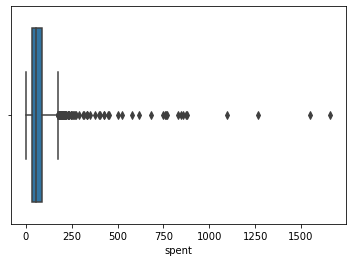

****************************************

Desctiptive statistics of spent variable:
count    2233.000000
mean       74.142960
std        92.638056
min         0.340320
25%        33.900000
50%        56.010000
75%        90.690000
max      1659.400000
Name: spent, dtype: float64


In [19]:
# Create boxplot of 'spent' variable in dataframe 'actovity'
sns.boxplot(x=activity['spent'])
# Display the plot
plt.show()
print("**"*20+'\n')
print("Desctiptive statistics of spent variable:\n{}".format(activity.spent.describe()))

- Most of the values in the 'spent' variable are below 91, with a median value of 56. However, there are also outliers in the data that need to be considered

In [20]:
# Calculate the first and third quartiles and IQR for 'spent' variable in dataframe 'df'
Q1 = activity['spent'].quantile(0.25)
Q3 = activity['spent'].quantile(0.75)
IQR = Q3 - Q1

# Set threshold for identifying outliers
threshold = 3

# Find outliers based on the IQR method
outliers = activity[(activity['spent'] < Q1 - threshold * IQR) | (activity['spent'] > Q3 + threshold * IQR)]
outliers

,uid,dt,device,spent
39,1001037,2023-01-31,I,879.100000
54,1001425,2023-01-25,A,309.800000
91,1002163,2023-02-02,A,274.290000
165,1003941,2023-01-27,NaN,844.700000
347,1008085,2023-01-27,A,1266.800000
357,1008198,2023-02-03,A,771.900000
401,1009232,2023-02-02,I,454.200000
406,1009288,2023-01-25,I,1094.800000
426,1009810,2023-01-25,I,854.800000
481,1011140,2023-01-26,A,291.900000


## Summary of Issues Identified During the Assessment Stage
Overall, the three datasets are in good shape and don't require extensive data cleaning. However, a few quality and tidiness issues were identified:
- Missing values were identified in the `country`, `gender`, and `device` columns.
- The `dt` and `join_dt` columns are not in datetime format.
- The `dt` and `join_dt` columns could be renamed to be more informative.
- The `uid` and `id` columns are not in string format.
- `device`,`group`, `country` and `gender` columns are not categorical.
- Merge the `groups` and `users` datasets using inner join as the have equal rows and no duplicates. Then use a left join to merge the combined dataset with the `activity` dataset. 
- Create a dummy variable to calculate the conversion rate. 
- There are outliers in the `spent` variable that need to be considered.

## Cleaning Data
In this section, we will clean all of the issues documented while assessing. 

In [21]:
# make a copy of original datasets
users_copy = users.copy()
groups_copy = groups.copy()
activity_copy = activity.copy()

**Define: remove outliersfrom `spent` variable using IQR method with the threshold of 3  \
**Code:**

In [22]:
activity_copy = activity_copy.drop(outliers.index)

**Test:**

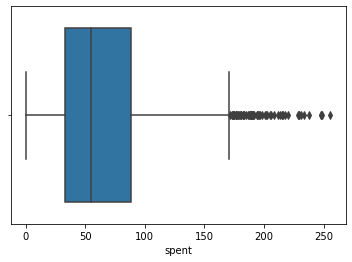

****************************************

Desctiptive statistics of spent variable after removing outliers:
count    2198.000000
mean       65.401355
std        43.697671
min         0.340320
25%        33.542500
50%        55.290000
75%        88.575000
max       255.660000
Name: spent, dtype: float64


In [23]:
# Create boxplot of 'spent' variable in dataframe 'actovity'
sns.boxplot(x=activity_copy['spent'])
# Display the plot
plt.show()
print("**"*20+'\n')
print("Desctiptive statistics of spent variable after removing outliers:\n{}".format(activity_copy.spent.describe()))

**Define: remove missing values using .dropna** \
`users` dataset has a relatively high percentage of missing values for the gender column. However, we will drop them considering the large number of observations in the overall dataset.   
**Code:**

In [24]:
users_copy.dropna(inplace=True)
groups_copy.dropna(inplace=True)
activity_copy.dropna(inplace=True)

**Test:**

In [25]:
users_copy.isnull().sum()

id         0
country    0
gender     0
dtype: int64

In [26]:
groups_copy.isnull().sum()

uid        0
group      0
join_dt    0
device     0
dtype: int64

In [27]:
activity_copy.isnull().sum()

uid       0
dt        0
device    0
spent     0
dtype: int64

In [28]:
# Merge the 'users_copy' and 'groups_copy' datasets
df1 = pd.merge(users_copy, groups_copy, left_on='id', right_on='uid')
df1 = df1.drop('uid', axis=1)
df1.head()

,id,country,gender,group,join_dt,device
0,1000000,CAN,M,B,2023-01-28,I
1,1000001,BRA,M,A,2023-01-27,A
2,1000002,FRA,M,A,2023-02-01,A
3,1000003,BRA,M,B,2023-01-25,I
4,1000004,DEU,F,A,2023-02-04,A


For further analysis, we will need to add two more columns to the `df1` dataset from the `activity_copy` dataset - `device` and `spent`. As we saw above there are multiple purchases per user so we will need to group our data by `uid`. We would also check whether all the users who made multiple purchases have the same device type - if so we will take only the `spent` column from the `activity_copy` dataset.

In [29]:
# group by uid and count number of unique device types
device_counts = activity_copy.groupby('uid')['device'].nunique()

# find ids with multiple device types
ids_with_multiple_devices = device_counts[device_counts > 1]

if not ids_with_multiple_devices.empty:
    print("There are rows for which id is the same but the device type is different:")
    print(activity_clean[activity_clean['uid'].isin(ids_with_multiple_devices.index)])
else:
    print("All rows have the same device type for each id.")

All rows have the same device type for each id.


In [30]:
# Group activity_copy dataframe by 'uid' and sum up the 'spent' column
df2 = activity_copy.groupby('uid')['spent'].sum()

# Merge df1 and df2 based on 'id' and 'uid' columns, respectively
df_main = pd.merge(df1,df2,left_on='id',right_on='uid',how='left')
df_main.head()

,id,country,gender,group,join_dt,device,spent
0,1000000,CAN,M,B,2023-01-28,I,NaN
1,1000001,BRA,M,A,2023-01-27,A,NaN
2,1000002,FRA,M,A,2023-02-01,A,NaN
3,1000003,BRA,M,B,2023-01-25,I,NaN
4,1000004,DEU,F,A,2023-02-04,A,NaN


In [31]:
# Add a new column 'attrition_flag' to the main dataframe based on whether the 'spent' column is null or not
df_main['attrition_flag'] = (~df_main['spent'].isnull()).astype(int)
df_main.head()

,id,country,gender,group,join_dt,device,spent,attrition_flag
0,1000000,CAN,M,B,2023-01-28,I,NaN,0
1,1000001,BRA,M,A,2023-01-27,A,NaN,0
2,1000002,FRA,M,A,2023-02-01,A,NaN,0
3,1000003,BRA,M,B,2023-01-25,I,NaN,0
4,1000004,DEU,F,A,2023-02-04,A,NaN,0


In [32]:
# Replaces all NaN values in the 'spent' column of the main dataframe with 0
df_main['spent'] = df_main['spent'].fillna(0)
df_main.head()

,id,country,gender,group,join_dt,device,spent,attrition_flag
0,1000000,CAN,M,B,2023-01-28,I,0.0,0
1,1000001,BRA,M,A,2023-01-27,A,0.0,0
2,1000002,FRA,M,A,2023-02-01,A,0.0,0
3,1000003,BRA,M,B,2023-01-25,I,0.0,0
4,1000004,DEU,F,A,2023-02-04,A,0.0,0


**Define: correct wrong data types** \
**Define: rename `join_dt` column to `test_join_date`** \
**Code:**

In [33]:
df_main.id = df_main.id.astype(str)
df_main.join_dt = pd.to_datetime(df_main.join_dt)
df_main.device = df_main.device.astype('category')
df_main.country = df_main.country.astype('category')
df_main.group = df_main.group.astype('category')
df_main.gender = df_main.gender.astype('category')
df_main = df_main.rename(columns={'join_dt': 'test_join_date'})

**Test:**

In [34]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41287 entries, 0 to 41286
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              41287 non-null  object        
 1   country         41287 non-null  category      
 2   gender          41287 non-null  category      
 3   group           41287 non-null  category      
 4   test_join_date  41287 non-null  datetime64[ns]
 5   device          41287 non-null  category      
 6   spent           41287 non-null  float64       
 7   attrition_flag  41287 non-null  int32         
dtypes: category(4), datetime64[ns](1), float64(1), int32(1), object(1)
memory usage: 1.6+ MB


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV files.

In [35]:
df_main.to_csv('df_main.csv', index=False)

## Descriptive analysis

**Question**  
What is the distribution of users in each test group (control vs test)?  
**Visualisation**

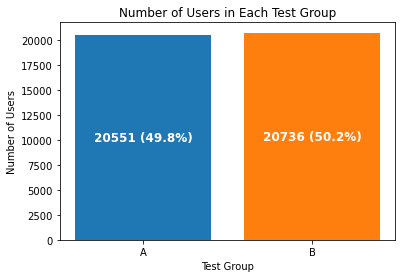

In [36]:
# count the number of users in each group
group_counts = df_main["group"].value_counts()[["A", "B"]]

# calculate the percentage of users in each group
group_percentages = group_counts / sum(group_counts) * 100

# create a bar chart with blue and orange colors
bars = plt.bar(["A", "B"], group_counts.values, color=['tab:blue', 'tab:orange'])

# add value and percentage labels inside the bars
for i, v in enumerate(group_counts.values):
    plt.text(i, v/2, str(v) + " ({:.1f}%)".format(group_percentages[i]), ha='center', va='center', color='white', fontweight='bold', fontsize=12)

# add labels and title
plt.xlabel("Test Group")
plt.ylabel("Number of Users")
plt.title("Number of Users in Each Test Group")

# display the chart
plt.show()

In [37]:
# Count the number of unique users in the selected rows
num_users_in_test = len(df_main['id'].unique())

# Print the result
print("The number of users involved in test is {}.".format(num_users_in_test))

The number of users involved in test is 41287.


**Observation**  
 There were 20551 users in the treatment (Group A), 20736 users in the control (Group B), and 41278 total.

**Question**  
How long does the expariment run?

In [38]:
# Find the earliest and latest join dates
earliest_date = df_main["test_join_date"].min()
latest_date = df_main["test_join_date"].max()

# Calculate the duration of the experiment
experiment_duration = latest_date - earliest_date

# Print the start and end dates and the duration of the experiment
print("The experiment ran from", earliest_date.strftime("%Y-%m-%d"), "to", latest_date.strftime("%Y-%m-%d"))
print("The experiment ran for a total of", experiment_duration.days, "days.")

The experiment ran from 2023-01-25 to 2023-02-06
The experiment ran for a total of 12 days.


**Question**  
Are the groups balanced in terms of user demographics (country, gender, device)?  
**Visualisation**

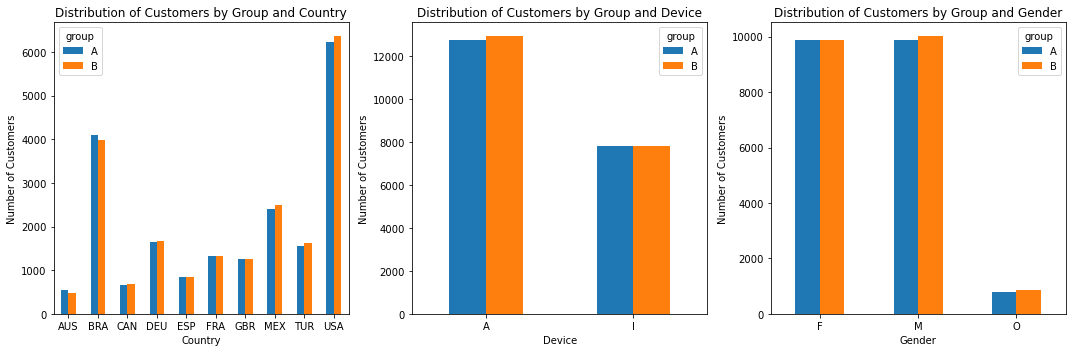

In [39]:
# create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define the columns to group by and plot titles for each plot
columns = [('country', 'Country'), ('device', 'Device'), ('gender', 'Gender')]

# Loop over the columns to group by and plot titles
for i, (column, title) in enumerate(columns):
    # Group the data by the 'group' and column
    groups = df_main.groupby(['group', column])
    # Count the number of occurrences of each item within each group and reshape the data
    # to create a DataFrame where the rows correspond to items and the columns correspond
    # to groups
    counts = groups.size().unstack('group', fill_value=0)
    # Plot a bar chart of the counts for each item and group, using blue for group A and
    # orange for group B
    counts.plot.bar(ax=axs[i], color=['tab:blue', 'tab:orange'])
    axs[i].set_xticklabels(counts.index, rotation=0)
    # Set the title, x-axis label, and y-axis label of the chart
    axs[i].set_title(f'Distribution of Customers by Group and {title}')
    axs[i].set_xlabel(title)
    axs[i].set_ylabel('Number of Customers')

# adjust the layout and spacing of the subplots
fig.tight_layout()

# Display the chart
plt.show()

**Observation**  
- The test and control groups are well-balanced in terms of demographics
- The majority of users are from the USA and Brazil
- Users are using either iOS or Android devices, with a slightly higher percentage of Android users.

**Question**  
What was the conversion rate of all users and across groups?

In [40]:
# Calculate the overall conversion rate
conversion_rate = df_main.attrition_flag.sum()/len(df_main)

# Print the result
print("The conversion rate of all users is {:.2%}".format(conversion_rate))

The conversion rate of all users is 4.13%


In [41]:
# Calculate the conversion rate by groups
conversion_rate = df_main.groupby('group').attrition_flag.mean()*100

# Print the result
print("The conversion rate for the control and treatment groups(%):\n {}".format(round(conversion_rate,2)))

The conversion rate for the control and treatment groups(%):
 group
A    3.79
B    4.48
Name: attrition_flag, dtype: float64


**Visualisation**

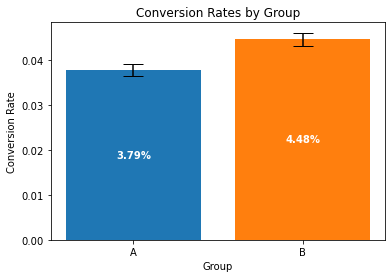

In [42]:
# Calculate the conversion rate for each group
cr_control = df_main.loc[df_main['group'] == 'A', 'attrition_flag'].mean()
cr_test = df_main.loc[df_main['group'] == 'B', 'attrition_flag'].mean()

# Calculate the standard error for each group
se_control = df_main.loc[df_main['group'] == 'A', 'attrition_flag'].sem()
se_test = df_main.loc[df_main['group'] == 'B', 'attrition_flag'].sem()

# Visualize the conversion rates as a bar chart with error bars and value labels inside the bars
fig, ax = plt.subplots()
ax.bar(['A', 'B'], [cr_control, cr_test], yerr=[se_control, se_test], capsize=10, color=['tab:blue', 'tab:orange'])
ax.set_title('Conversion Rates by Group')
ax.set_xlabel('Group')
ax.set_ylabel('Conversion Rate')
for i, v in enumerate([cr_control, cr_test]):
    ax.text(i, v/2, '{:.2%}'.format(v), ha='center', va='center', fontweight='bold', color='white')
plt.show()

**Observation**
- The conversion rate of all users is 4.13% 
- The conversion rates for the control and treatment groups are 3.79% and 4.48% respectively

**Question**  
What is the average amount spent per user for the control and treatment groups?

In [43]:
# calculate the average amount spent per user for each group
average_spent_per_user = df_main.groupby('group')['spent'].mean()

# print the results
print('Average amount spent per user:\n {}'.format(round(average_spent_per_user,3)))

Average amount spent per user:
 group
A    2.920
B    2.834
Name: spent, dtype: float64


**Visualization**

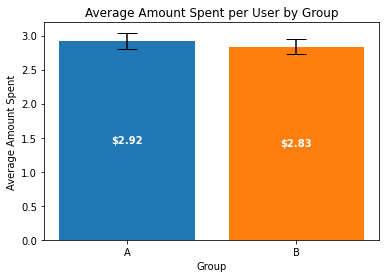

In [44]:
# Calculate the average amount spent per user for each group
avg_spent_control = df_main.loc[df_main['group'] == 'A', 'spent'].mean()
avg_spent_test = df_main.loc[df_main['group'] == 'B', 'spent'].mean()

# Calculate the standard error for each group
se_control = df_main.loc[df_main['group'] == 'A', 'spent'].sem()
se_test = df_main.loc[df_main['group'] == 'B', 'spent'].sem()

# Visualize the average amount spent as a bar chart with error bars
fig, ax = plt.subplots()
ax.bar(['A', 'B'], [avg_spent_control, avg_spent_test], yerr=[se_control, se_test], capsize=10, color=['tab:blue', 'tab:orange'])
ax.set_title('Average Amount Spent per User by Group')
ax.set_xlabel('Group')
ax.set_ylabel('Average Amount Spent')
for i, v in enumerate([avg_spent_control, avg_spent_test]):
    ax.text(i, v/2, '${:.2f}'.format(v), ha='center', va='center', fontweight='bold', color='white')
plt.show()

## Hypothesis testing

**Question**  
What is the 95% confidence interval for the conversion rate of users in the control and treatment? \
Use the normal distribution.

In [45]:
# Calculate the conversion rate for the control group
control = df_main[df_main['group'] == 'A']
p = control['attrition_flag'].mean()

# Calculate the standard error of the sample proportion
n = len(control)
SE = np.sqrt(p*(1-p)/n)

# Calculate the confidence interval
z = stats.norm.ppf(1-(1-0.95)/2) # z-score for 95% confidence interval
CI = (round(p - z*SE,4), round(p + z*SE,4))

print("The 95% confidence interval for the conversion rate of users in the control group is:", CI)

The 95% confidence interval for the conversion rate of users in the control group is: (0.0353, 0.0405)


In [46]:
# Calculate the conversion rate for the treatment group
control = df_main[df_main['group'] == 'B']
p = control['attrition_flag'].mean()

# Calculate the standard error of the sample proportion
n = len(control)
SE = np.sqrt(p*(1-p)/n)

# Calculate the confidence interval
z = stats.norm.ppf(1-(1-0.95)/2) # z-score for 95% confidence interval
CI = (round(p - z*SE,4), round(p + z*SE,4))

print("The 95% confidence interval for the conversion rate of users in the treatment group is:", CI)

The 95% confidence interval for the conversion rate of users in the treatment group is: (0.0419, 0.0476)


**Question**  
Conduct a hypothesis test to see whether there is a difference in the conversion rate between the two groups. What are the resulting p-value and conclusion? \
Use the normal distribution and a 5% significance level. Use the pooled proportion for the standard error.

In [47]:
# calculate the pooled proportion for standard error
pooled_prop = (df_main[df_main['group']=='A']['attrition_flag'].sum() + df_main[df_main['group']=='B']['attrition_flag'].sum()) / (df_main[df_main['group']=='A'].shape[0] + df_main[df_main['group']=='B'].shape[0])

# calculate the test statistic
p_control = df_main[df_main['group']=='A']['attrition_flag'].mean()
p_treatment = df_main[df_main['group']=='B']['attrition_flag'].mean()
control_total = df_main[df_main['group']=='A'].shape[0]
treatment_total = df_main[df_main['group']=='B'].shape[0]
test_statistic = (p_control - p_treatment) / (pooled_prop * (1 - pooled_prop) * (1/control_total + 1/treatment_total))**0.5

# calculate the p-value
p_value = stats.norm.sf(abs(test_statistic)) * 2

# print the results
print('p-value: {:.4f}'.format(p_value))


# compare p-value with alpha
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a statistically significant difference in the conversion rate between the two groups.")
else:
    print("Fail to reject the null hypothesis. There is no statistically significant difference in the conversion rate between the two groups.")


p-value: 0.0005
Reject the null hypothesis. There is a statistically significant difference in the conversion rate between the two groups.


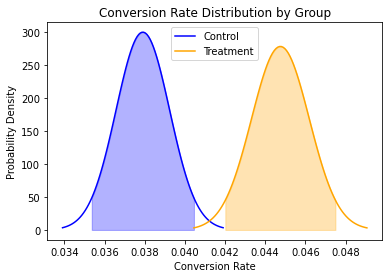

In [48]:
# Separate the data into control and treatment groups
control = df_main[df_main['group'] == 'A']
treatment = df_main[df_main['group'] == 'B']

# Calculate the conversion rate and standard error of the sample proportion for each group
p_control = control['attrition_flag'].mean()
p_treatment = treatment['attrition_flag'].mean()
n_control = len(control)
n_treatment = len(treatment)
SE_control = np.sqrt(p_control*(1-p_control)/n_control)
SE_treatment = np.sqrt(p_treatment*(1-p_treatment)/n_treatment)

# Calculate the confidence intervals for each group
z = stats.norm.ppf(1-(1-0.95)/2) # z-score for 95% confidence interval
CI_control = (p_control - z*SE_control, p_control + z*SE_control)
CI_treatment = (p_treatment - z*SE_treatment, p_treatment + z*SE_treatment)

# Plot the normal curves for the two groups
x_control = np.linspace(p_control - 3*SE_control, p_control + 3*SE_control, 100)
y_control = stats.norm.pdf(x_control, p_control, SE_control)
plt.plot(x_control, y_control, label='Control', color='blue')
x_treatment = np.linspace(p_treatment - 3*SE_treatment, p_treatment + 3*SE_treatment, 100)
y_treatment = stats.norm.pdf(x_treatment, p_treatment, SE_treatment)
plt.plot(x_treatment, y_treatment, label='Treatment', color='orange')

# Shade the area under the curves that correspond to the confidence intervals
plt.fill_between(x_control, 0, y_control, where=((x_control>=CI_control[0]) & (x_control<=CI_control[1])), color='blue', alpha=0.3)
plt.fill_between(x_treatment, 0, y_treatment, where=((x_treatment>=CI_treatment[0]) & (x_treatment<=CI_treatment[1])), color='orange', alpha=0.3)

# Add labels and legend
plt.xlabel('Conversion Rate')
plt.ylabel('Probability Density')
plt.title('Conversion Rate Distribution by Group')
plt.legend()

# Show the plot
plt.show()

**Question**  
What is the 95% confidence interval for the difference in the conversion rate between the treatment and control (treatment-control)?  \
Use the normal distribution and unpooled proportions for the standard error.

In [49]:
# Calculate conversion rates for treatment and control groups
p1 = df_main[df_main['group'] == 'A']['attrition_flag'].mean()
p2 = df_main[df_main['group'] == 'B']['attrition_flag'].mean()
    
# Calculate sample sizes for treatment and control groups
n1 = df_main[df_main['group'] == 'A'].shape[0]
n2 = df_main[df_main['group'] == 'B'].shape[0]

# Calculate the difference in proportions
difference = p2 - p1

# Calculate the standard error using unpooled proportions
se = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)

# Calculate the margin of error using a 95% confidence level
margin_of_error = stats.norm.ppf(0.975) * se

# Calculate the confidence interval
CI = (difference - margin_of_error, difference + margin_of_error)

print("95% Confidence Interval: ({:.4f}, {:.4f})".format(CI[0], CI[1]))

95% Confidence Interval: (0.0030, 0.0107)


**Question**  
What is the 95% confidence interval for the average amount spent per user in the control? \
Use the t distribution. We are using a one-sample t-interval for means.

In [50]:
# Set the confidence level
confidence_level = 0.95

group_A = df_main[df_main['group'] == 'A']
group_B = df_main[df_main['group'] == 'B']

# calculate the average amount and the standard error spent per user in the group
mean = group_A.spent.mean()
std=group_A.spent.std()

# calculate the 95% confidence interval for the average amount spent per user in the control group
t_value = stats.t.ppf(1-(1-confidence_level)/2,group_A.shape[0]-1)
LCI = mean - t_value*std/math.sqrt(group_A.shape[0])
UCI = mean + t_value*std/math.sqrt(group_A.shape[0])

# print the results
print('95% confidence interval for the average amount spent per user in the control group: [{:.3f}, {:.3f}]'.format(LCI, UCI))

95% confidence interval for the average amount spent per user in the control group: [2.679, 3.160]


**Question**  
What is the 95% confidence interval for the average amount spent per user in the treatment? \
Use the t distribution.

In [51]:
# Set the confidence level
confidence_level = 0.95

# separate the two groups
group_A = df_main[df_main['group'] == 'A']
group_B = df_main[df_main['group'] == 'B']

# calculate the average amount and the standard error spent per user in the group
mean = group_B.spent.mean()
std=group_B.spent.std()

# calculate the 95% confidence interval for the average amount spent per user in the control group
t_value = stats.t.ppf(1-(1-confidence_level)/2,group_B.shape[0]-1)
LCI = mean - t_value*std/math.sqrt(group_B.shape[0])
UCI = mean + t_value*std/math.sqrt(group_B.shape[0])

# print the results
print('95% confidence interval for the average amount spent per user in the treatment group: [{:.3f}, {:.3f}]'.format(LCI, UCI))

95% confidence interval for the average amount spent per user in the treatment group: [2.617, 3.050]


**Question**  
Conduct a hypothesis test to see whether there is a difference in the average amount spent per user between the two groups. What are the resulting p-value and conclusion? \
Use the t distribution and a 5% significance level. Assume unequal variance.

In [52]:
# separate the two groups
group_A = df_main[df_main['group'] == 'A']
group_B = df_main[df_main['group'] == 'B']

# calculate the means and standard deviations
mean_A = group_A['spent'].mean()
mean_B = group_B['spent'].mean()
std_A = group_A['spent'].std()
std_B = group_B['spent'].std()

# conduct the two-sample t-test
t_stat, p_val = stats.ttest_ind(group_A['spent'], group_B['spent'], equal_var=False)

# print the results
print('Group A mean: {:.2f}'.format(mean_A))
print('Group B mean: {:.2f}'.format(mean_B))
print('Group A standard deviation: {:.2f}'.format(std_A))
print('Group B standard deviation: {:.2f}'.format(std_B))
print('t-statistic: {:.2f}'.format(t_stat))
print('p-value: {:.3f}'.format(p_val))

# determine if there is a significant difference
alpha = 0.05
if p_val < alpha:
    print('There is a significant difference between the two groups.')
else:
    print('There is no significant difference between the two groups.')

Group A mean: 2.92
Group B mean: 2.83
Group A standard deviation: 17.56
Group B standard deviation: 15.90
t-statistic: 0.52
p-value: 0.602
There is no significant difference between the two groups.


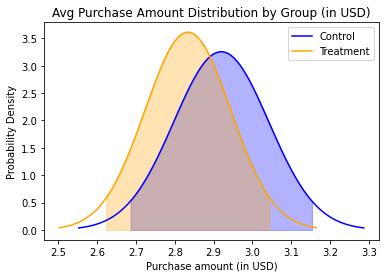

In [53]:
# Separate the data into control and treatment groups
control = df_main[df_main['group'] == 'A']
treatment = df_main[df_main['group'] == 'B']

# Calculate the mean and standard error of the mean for each group
mean_control = control['spent'].mean()
mean_treatment = treatment['spent'].mean()
n_control = len(control)
n_treatment = len(treatment)
SE_control = control['spent'].std(ddof=1) / np.sqrt(n_control)
SE_treatment = treatment['spent'].std(ddof=1) / np.sqrt(n_treatment)

# Calculate the degrees of freedom for the t-distribution
df_control = n_control - 1
df_treatment = n_treatment - 1

# Calculate the confidence intervals for each group
t = stats.t.ppf(1-(1-0.95)/2, df=df_control) # t-score for 95% confidence interval
CI_control = (mean_control - t*SE_control, mean_control + t*SE_control)
t = stats.t.ppf(1-(1-0.95)/2, df=df_treatment) # t-score for 95% confidence interval
CI_treatment = (mean_treatment - t*SE_treatment, mean_treatment + t*SE_treatment)

# Plot the normal curves for the two groups
x_control = np.linspace(mean_control - 3*SE_control, mean_control + 3*SE_control, 100)
y_control = stats.t.pdf(x_control, df=df_control, loc=mean_control, scale=SE_control)
plt.plot(x_control, y_control, label='Control', color='blue')
x_treatment = np.linspace(mean_treatment - 3*SE_treatment, mean_treatment + 3*SE_treatment, 100)
y_treatment = stats.t.pdf(x_treatment, df=df_treatment, loc=mean_treatment, scale=SE_treatment)
plt.plot(x_treatment, y_treatment, label='Treatment', color='orange')

# Shade the area under the curves that correspond to the confidence intervals
plt.fill_between(x_control, 0, y_control, where=((x_control>=CI_control[0]) & (x_control<=CI_control[1])), color='blue', alpha=0.3)
plt.fill_between(x_treatment, 0, y_treatment, where=((x_treatment>=CI_treatment[0]) & (x_treatment<=CI_treatment[1])), color='orange', alpha=0.3)

# Add labels and legend
plt.xlabel('Purchase amount (in USD)')
plt.ylabel('Probability Density')
plt.title('Avg Purchase Amount Distribution by Group (in USD)')
plt.legend()

# Show the plot
plt.show()

**Question**  
What is the 95% confidence interval for the difference in the average amount spent per user between the treatment and the control (treatment-control)? \
Use the t distribution and assume unequal variance.

In [54]:
# Separate the treatment and control groups
treatment = df_main[df_main['group'] == 'B']['spent']
control = df_main[df_main['group'] == 'A']['spent']

# Calculate the sample means and standard deviations
mean_diff = np.mean(treatment) - np.mean(control)
var_t = np.var(treatment, ddof=1)
var_c = np.var(control, ddof=1)
n_t = len(treatment)
n_c = len(control)

# Calculate the pooled standard deviation
pooled_std = np.sqrt(var_t/n_t + var_c/n_c)

# Calculate the degrees of freedom
df = (var_t/n_t + var_c/n_c)**2 / ((var_t/n_t)**2/(n_t-1) + (var_c/n_c)**2/(n_c-1))

# Calculate the t-statistic
t_stat = mean_diff / pooled_std

# Calculate the 95% confidence interval for the difference in means
margin_of_error = stats.t.ppf(0.975, df) * pooled_std
lower_ci = mean_diff - margin_of_error
upper_ci = mean_diff + margin_of_error

print(f"The 95% confidence interval for the difference in means is ({lower_ci:.3f}, {upper_ci:.3f})")

The 95% confidence interval for the difference in means is (-0.409, 0.237)
